In [1]:
import sys
import os
import torch
import cv2 as cv
import numpy as np
import torchvision
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import random
from torch.utils.data.sampler import SubsetRandomSampler
from skimage.io import imread, imshow

from PIL import Image

In [2]:
#Using GPU
print(sys.version)
device = 'cuda'
#Checking for GPU
print(torch.version.cuda)
print(torch.cuda.device_count())
print(torch.cuda.is_available())

3.7.8 (tags/v3.7.8:4b47a5b6ba, Jun 28 2020, 08:53:46) [MSC v.1916 64 bit (AMD64)]
10.2
1
True


In [3]:
def HPF(image):
    kernel5x5 = np.array([[-1, -1, -1, -1, -1],
    [-1, 1, 2, 1, -1],
    [-1, 2, 4, 2, -1],
    [-1, 1, 2, 1, -1],
    [-1, -1, -1, -1, -1]])
    img = cv.filter2D(image, -1, kernel5x5)
    img = image - cv.GaussianBlur(image, (21,21), 0)
    #img = image - cv.medianBlur(image, 11, 0)
    return img

(224, 224, 3)


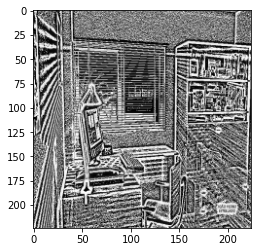

In [6]:
n = random.randint(0,799)
cg_image = cv.imread('./data_processed2/CG/cg_' + str(n) + '.jpg')
cg_image = cv.resize(cg_image, (224, 224), interpolation=cv.INTER_AREA)
print(cg_image.shape)

plt.imshow(cg_image, cmap='gray')

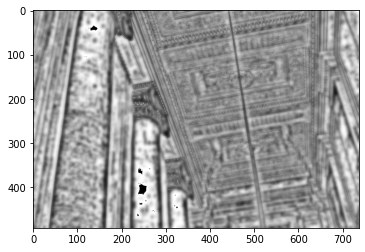

In [7]:
pi_image = cv.imread('./data_processed2/PI2/pi_' + str(n) + '.jpg', 0)
pi_image = HPF(pi_image)
plt.imshow(pi_image, cmap='gray')

In [8]:
pi_cg_list = (list(), list())
image_list = (list(), list())
num= 0
num2=0

for j in os.listdir('./data_processed2/PI2/'):
    if not j.startswith('.') and (j.split('.')[1] == 'jpg'):
        
        img = cv.imread('./data_processed2/PI2/' + str(j))
        #img = HPF(img)
        #img = cv.resize(img, (224, 224), interpolation=cv.INTER_AREA)
        #img = cv.merge((img, img, img))
        pil_image = Image.fromarray(img)
        
        #pil_image = torch.from_numpy(img)
        #pil_image = pil_image.reshape(3, 224, 224)
        num+=1
        pi_cg_list[0].append(j)
        image_list[0].append(pil_image)


for j in os.listdir('./data_processed2/CG/'):
    if not j.startswith('.') and (j.split('.')[1] == 'jpg'):
        
        img = cv.imread('./data_processed2/CG/' + str(j))
        #img = HPF(img)
        #img = cv.resize(img, (224, 224), interpolation=cv.INTER_AREA)
        #img = cv.merge((img, img, img))
        pil_image = Image.fromarray(img)
        
        #pil_image = torch.from_numpy(img)
        #pil_image = pil_image.reshape(3, 224, 224)
        num2+=1
        pi_cg_list[1].append(j)
        image_list[1].append(pil_image)

print(num2, num)
#print(pi_cg_list[1])
print(len(image_list[1]))

800 800
800


In [9]:
image_size = 224
data_transform = transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.RandomResizedCrop(size=image_size, scale=(0.9, 1.1)),
                transforms.RandomRotation(degrees=10),
                transforms.ColorJitter(),
                transforms.RandomHorizontalFlip(0.2),
                transforms.Resize(size=image_size),  # Image net standards
                #transforms.Grayscale(),
                transforms.ToTensor(),
                #transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])  # Imagenet standards
                #transforms.ToTensor(), 
                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ])

In [10]:
class PivsCgDataset(Dataset):

    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform
    
    def __len__(self):
        # Return the length of the dataset
        l = len(image_list[0]) + len(image_list[1])
        return l
    
    def __getitem__(self, idx):
        #print(idx)
        # Return the observation based on an index. Ex. dataset[0] will return the first element from the dataset, in this case the image and the label.
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        #print(idx)
        
        if idx < 800:
            image = image_list[0][idx]
            image = data_transform(image)
            label = 0
        else:
            image = image_list[1][idx-800]
            image = data_transform(image)
            label = 1
    
        return (image, label)

In [11]:
dataset = PivsCgDataset(image_list, transform = data_transform)
print(dataset[800])
print(len(dataset))

x_data = []
y_data = []
image_size = 224

batch = 8
random_seed = random.randint(1, 100)

dataset_size = len(dataset)
split = int(0.1*dataset_size)
print('Size of dataset is: ', dataset_size)
print('Split value: ', split)
indices = list(range(dataset_size))

np.random.seed(random_seed)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, sampler=train_sampler,
                                            num_workers = 0)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, sampler=valid_sampler,
                                            num_workers = 0)

print(len(train_loader))
print(len(valid_loader))


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 1)
1600
Size of dataset is:  1600
Split value:  160
180
20


In [12]:
# Iterate through the dataloader once
testiter = iter(valid_loader)
features, labels = next(testiter)
print(features.shape)
print(labels.shape)

#for f, l in train_loader:
    #print(l)

torch.Size([8, 3, 224, 224])
torch.Size([8])


Image shape:  224


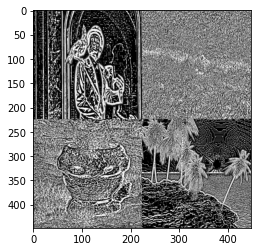

In [13]:
img_shape = 224
print('Image shape: ', img_shape)
root = './data_processed2'

final_img = None

labels = ['PI2', 'CG']

for i in range(2):
    row_img = None
    for j in range(2):
        
        imgpath = root + '/' + labels[i] + '/' + str(pi_cg_list[i][random.randint(1, 799)])
        #print(imgpath)
        img = cv.imread(imgpath)
        img = cv.resize(img, (img_shape, img_shape), interpolation = cv.INTER_AREA)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            
        if np.any(row_img == None):
            row_img = img
        else:
            row_img = np.hstack((row_img, img))
            
    if np.any(final_img == None):
            final_img = row_img
    else:
        final_img = np.vstack((final_img, row_img))  
                        
plt.imshow(final_img)
#cv.waitKey(0)
#cv.destroyAllWindows()        

In [14]:
num_classes = 2

class CaffeNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1)
        #self.conv1_bn = nn.BatchNorm3d(96)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.norm1 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)

        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2, groups=2)
        #self.conv2_bn = nn.BatchNorm3d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.norm2 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)

        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        #self.conv3_bn = nn.BatchNorm3d(384)

        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1, groups=2)
        #self.conv4_bn = nn.BatchNorm3d(384)

        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2)
        #self.conv5_bn = nn.BatchNorm3d(256)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc6 = nn.Linear(6400, 4096)
        self.fc7 = nn.Linear(4096, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        h = x.view(-1, 3, 224, 224)

        h = self.relu(self.conv1(h))
        #print(h.shape)
        h = self.pool1(h)
        h = self.norm1(h)
        #print(h.shape)

        h = self.relu(self.conv2(h))
        h = self.pool2(h)
        h = self.norm2(h)
        #print(h.shape)

        h = self.relu(self.conv3(h))

        h = self.relu(self.conv4(h))

        h = self.relu(self.conv5(h))
        h = self.pool5(h)
        #print(h.shape)

        h = h.view(-1, 6400)
        h = self.relu(self.fc6(h))
        h = self.relu(self.fc7(h))
        h = self.softmax(h)
        #print(h.shape)
        return h


In [15]:
model = CaffeNet()
    
print(model)

CaffeNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (pool5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc6): Linear(in_features=6400, out_features=4096, bias=True)
  (fc7): Linear(in_features=4096, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)


In [18]:
total_params = sum(p.numel() for p in model.parameters())

print(f'{total_params:,} total parameters')

total_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'{total_trainable:,} trainable parameters.')

21,613,250 total parameters
21,613,250 trainable parameters.


In [19]:
#for f, l in train_loader :
    #print(f.shape)

In [20]:
# Move to gpu
model = model.to('cuda')
# Distribute across 2 gpus
model = nn.DataParallel(model)
device = 'cuda'
loss_func = F.cross_entropy


In [21]:
def accuracy(out, yb):
    pred = torch.argmax(out, keepdim= False, dim=1)
    return (pred == yb).float().mean() 

In [22]:
def fit(model, epochs, train_loader, valid_loader, opt):
    losses = []
    accuracies = []
    
    for epoch in range(epochs):
        train_loss =0
        train_acc =0
        model.train()
        for xb, yb in train_loader:
            xb =xb.to(device)
            yb = yb.to(device)
            pred = model(xb.float())
            pred.to(device)
            #print(pred, pred.shape)
            #print(yb, yb.shape)
            train_acc += accuracy(pred, yb)
            loss = loss_func(pred, yb)
            train_loss += loss
            #back propogation
            loss.backward()
            opt.step()
            opt.zero_grad()      

        losses.append(train_loss)
        print("Iteration no: "+ str(epoch*20+1020), "loss = "+str(losses[epoch].item()))
        print("Accuracy of train set:", train_acc/len(train_loader))
        accuracies.append(train_acc/len(train_loader))
        lr_scheduler.step(train_loss/len(train_loader))
        
        
        model.eval()    
        with torch.no_grad():
            valid_acc=0
            loss_valid = 0
            for xb_valid, yb_valid in valid_loader:
                xb_valid = xb_valid.to(device)
                yb_valid = yb_valid.to(device)
                pred_valid = model(xb_valid.float())
                pred_valid.to(device)
                valid_acc += accuracy(pred_valid, yb_valid)
                loss_valid += loss_func(pred_valid, yb_valid)
            print("Accuracy of validation set :", valid_acc/len(valid_loader))
    
    #losses = np.array(losses)
    #plt.plot(losses)
    #plt.ylabel("loss")
    #plt.xlabel("iterations")
    #plt.show()
    return losses, accuracies

In [23]:
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.999), lr = 0.0005)#, weight_decay = 0.0002)

In [24]:
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True, eps = 10e-8)

loss_list1, accuracy_list1 = fit(model, 40, train_loader, valid_loader, optimizer)

Iteration no: 1020 loss = 115.96285247802734
Accuracy of train set: tensor(0.6201, device='cuda:0')
Accuracy of validation set : tensor(0.4813, device='cuda:0')
Iteration no: 1040 loss = 108.96035766601562
Accuracy of train set: tensor(0.6792, device='cuda:0')
Accuracy of validation set : tensor(0.7250, device='cuda:0')
Iteration no: 1060 loss = 103.84927368164062
Accuracy of train set: tensor(0.7194, device='cuda:0')
Accuracy of validation set : tensor(0.6375, device='cuda:0')
Iteration no: 1080 loss = 104.5986557006836
Accuracy of train set: tensor(0.7167, device='cuda:0')
Accuracy of validation set : tensor(0.7188, device='cuda:0')
Iteration no: 1100 loss = 101.28667449951172
Accuracy of train set: tensor(0.7326, device='cuda:0')
Accuracy of validation set : tensor(0.6750, device='cuda:0')
Iteration no: 1120 loss = 98.60233306884766
Accuracy of train set: tensor(0.7410, device='cuda:0')
Accuracy of validation set : tensor(0.6250, device='cuda:0')
Iteration no: 1140 loss = 98.9205169

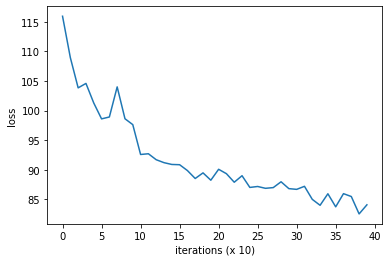

In [25]:
loss = []
for l in loss_list1:
    loss.append(l.tolist())
plt.plot(loss)
plt.ylabel("loss")
plt.xlabel("iterations")
plt.savefig('./loss-1.png')

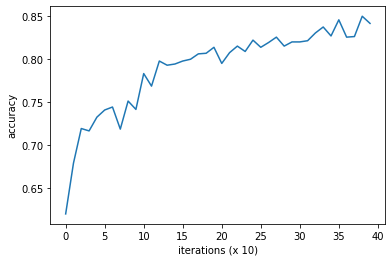

In [26]:
accurate = []
for a in accuracy_list1:
    accurate.append(a.tolist())
plt.plot(accurate)
plt.ylabel("accuracy")
plt.xlabel("iterations")
plt.savefig('./accuracy-1.png')

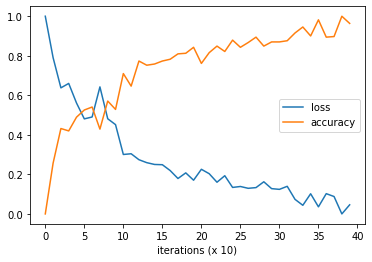

In [27]:
m_l = min(loss)
M_l = max(loss)
loss_scaled = np.asarray(loss)
loss_scaled = (loss_scaled - m_l)/(M_l - m_l)

m_a = min(accurate)
M_a = max(accurate)
accuracy_scaled = np.asarray(accurate)
accuracy_scaled = (accuracy_scaled - m_a)/(M_a - m_a)


plt.plot(loss_scaled, label = 'loss')
plt.plot(accuracy_scaled, label = 'accuracy')
plt.legend()
plt.xlabel("iterations")
plt.savefig('./scaled-1.png')

In [28]:
torch.save(model, './resnet34-trained-1.pth')
